In [1]:
%load_ext autoreload
%autoreload 2

This notebook contains basic usage of the `FunctionClassifier`.

In [2]:
import numpy as np
import pandas as pd 

from hulearn.datasets import load_titanic
from hulearn.classification import FunctionClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
df = load_titanic(as_frame=True)
X, y = df.drop(columns=['survived']), df['survived']

In [4]:
def last_name(dataf, sex='male', pclass=1):
    predicate = (dataf['sex'] == sex) & (dataf['pclass'] == pclass)
    return np.array(predicate).astype(int)

def fare_based(dataf, threshold=10):
    return np.array(dataf['fare'] > threshold).astype(int)

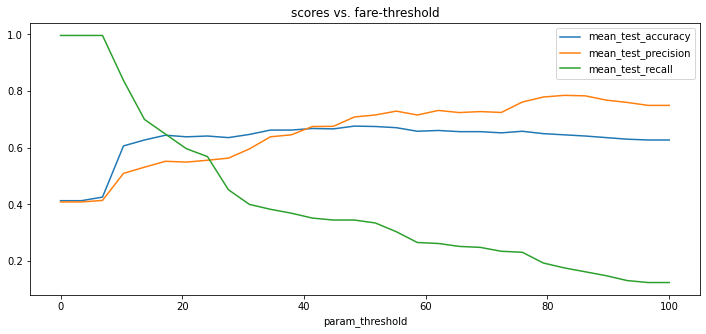

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, make_scorer

mod = FunctionClassifier(fare_based, threshold=10)
grid = GridSearchCV(mod, 
                    cv=2, 
                    param_grid={'threshold': np.linspace(0, 100, 30)},
                    scoring={'accuracy': make_scorer(accuracy_score), 
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                    refit='accuracy'
                )
grid.fit(X, y)

score_df = (pd.DataFrame(grid.cv_results_)
  .set_index('param_threshold')
  [['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']])

score_df.plot(figsize=(12, 5), title="scores vs. fare-threshold");

In [6]:
score_df.sort_values("mean_test_precision", ascending=False).head()

,mean_test_accuracy,mean_test_precision,mean_test_recall
param_threshold,,,
82.758621,0.645658,0.785038,0.175862
86.206897,0.641457,0.783333,0.162069
79.310345,0.649860,0.779151,0.193103
89.655172,0.635854,0.768199,0.148276
75.862069,0.658263,0.761364,0.231034


We seem to be able to achieve 78.5% precision given the right threshold! What about a `RandomForest`?

In [7]:
from sklearn.ensemble import RandomForestClassifier

X_subset = X.assign(sex=lambda d: d['sex'] == 'female')[['pclass', 'sex', 'age', 'fare']]

grid = GridSearchCV(RandomForestClassifier(), 
                    cv=10, 
                    param_grid={},
                    scoring={'accuracy': make_scorer(accuracy_score), 
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                    refit='accuracy'
                )

pd.DataFrame(grid.fit(X_subset, y).cv_results_)[['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,mean_test_accuracy,mean_test_precision,mean_test_recall
0,0.81385,0.791315,0.741379


Our simple threhold model seems competative on precision. This is interesting.

# Bigger Grid 

We're not limited to just one parameter for our grid. With the `FunctionClassifier` you can define many.

In [8]:
def custom_predict(dataf, sex='male', pclass=1):
    predicate = (dataf['sex'] == sex) & (dataf['pclass'] == pclass)
    return np.array(predicate).astype(int)

mod = FunctionClassifier(custom_predict, pclass=10, sex='male')
grid = GridSearchCV(mod, 
                    cv=2, 
                    param_grid={'pclass': [1, 2, 3], 'sex': ['male', 'female']},
                    scoring={'accuracy': make_scorer(accuracy_score), 
                             'precision': make_scorer(precision_score),
                             'recall': make_scorer(recall_score)},
                    refit='accuracy')
grid.fit(X, y)

GridSearchCV(cv=2,
             estimator=FunctionClassifier(func=<function custom_predict at 0x10c19a290>,
                                          pclass=10, sex='male'),
             param_grid={'pclass': [1, 2, 3], 'sex': ['male', 'female']},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [9]:
pd.DataFrame(grid.cv_results_)[['param_pclass', 'param_sex', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

,param_pclass,param_sex,mean_test_accuracy,mean_test_precision,mean_test_recall
0,1,male,0.564426,0.384569,0.137931
1,1,female,0.704482,0.964246,0.282759
2,2,male,0.497199,0.151348,0.051724
3,2,female,0.680672,0.920588,0.234483
4,3,male,0.345938,0.150413,0.131034
5,3,female,0.582633,0.454386,0.162069
